In [1]:
#!pip install py2neo

import os
import pandas as pd
import matplotlib.pyplot as plt
import py2neo
from py2neo import Graph,Node,Relationship

import IPython

print ('py2neo version', py2neo.__version__)
%matplotlib inline

py2neo version 2021.2.3


In [2]:
# Connect the repository to the DB
db_url = 'neo4j@bolt://neo4j@localhost:7687'
db_pass = 'tweets'

graph = Graph(db_url, password = db_pass)

In [3]:
#consulta de prueba

nodos_tweet="MATCH(t:Tweet) RETURN t.id, t.text, t.like_count ORDER BY t.like_count DESC LIMIT 25"

#evaluamos las consultas
tweets=graph.run(nodos_tweet).to_data_frame() 

tweets

,t.id,t.text,t.like_count
0,1518623997054918657,I hope that even my worst critics remain on Tw...,3322952
1,1376712834269159425,#StopAsianHate\n#StopAAPIHate https://t.co/mOm...,2550038
2,1368913515977744385,아직 날씨가 쌀쌀하니 따뜻하게 입고 다니세요 !\n#JIMIN https://t.c...,2306319
3,1261298966160797696,태태와 함께! #0613FM_0515 https://t.co/TY0T3lO3YV,2277194
4,1524082224886579202,Hi https://t.co/Hg2BvVJubZ,2042623
5,1523465632502906880,"If I die under mysterious circumstances, it’s ...",1940777
6,1524082723555786753,Bye https://t.co/Tf4jXphMnD,1882691
7,1528987173927522304,とりあえずあと4話。 https://t.co/OwoB4ljp1x,1490711
8,1527669475910242305,I love him https://t.co/ys7WlVDBxb,1398807
9,1521202951230046210,As I was saying … https://t.co/tsGz6fCWuW,1370842


In [5]:
# conteo de nodos
nro_nodos_user="MATCH(u:User) RETURN Count(u)"
nro_nodos_tweet="MATCH(t:Tweet) RETURN Count(t)"
nro_nodos_hashtag="MATCH(h:Hashtag) RETURN Count(h)"

#evaluamos las consultas
result_users=graph.evaluate(nro_nodos_user)
result_tweets=graph.evaluate(nro_nodos_tweet)
result_hashtags=graph.evaluate(nro_nodos_hashtag)

#imprimo resultados
print(f'En la BD hay {result_users} nodos User, {result_tweets} nodos Tweet y {result_hashtags} nodos Hashtag.')


En la BD hay 55863 nodos User, 405389 nodos Tweet y 12884 nodos Hashtag.


In [7]:
# detalle de users y tweets

consulta = (
    "match (u:User) -[:TWEETED]-> (t:Tweet {country: 'UY'}) "
    "return count(distinct(u)), count(t);"
)

result_cons=graph.run(consulta).to_data_frame() 

print(f'Tweets posteados desde Uruguay con geolocalización activada: {result_cons.iloc[0,1]}')
print(f'Tweets sin geolocalización (referenciados por tweets con geolocalización): {result_tweets - result_cons.iloc[0,1]}')
print(f'Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: {result_cons.iloc[0,0]}')
print(f'Resto de los usuarios: {result_users - result_cons.iloc[0,0]}')


Tweets posteados desde Uruguay con geolocalización activada: 276546
Tweets sin geolocalización (referenciados por tweets con geolocalización): 128843
Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: 9309
Resto de los usuarios: 46554


In [10]:
# conteo de relaciones

consulta_1 = (
    "MATCH ()-[r]->() "
    "RETURN count(r);"
)

result_cons_1=graph.evaluate(consulta_1)

print(f'Hay {result_cons} relaciones')

consulta_2 = (
    "match ()-[r]->() "
    "with type(r) as rel_type, count(r) as number "
    "return rel_type, number;"
)

result_cons_2=graph.run(consulta_2).to_data_frame() 
result_cons_2

Hay 1098388 relaciones


,rel_type,number
0,TWEETED,405389
1,REPLY,185220
2,MENTIONS,427789
3,TAG,41782
4,QUOTE,38208


In [12]:
# usuarios con más seguidores

consulta = (
    "match (u:User) -[r:TWEETED]-> (t:Tweet) "
    "with u, count(t) as tweets_in_uy_conversation, u.name as name, u.followers as followers "
    "return name, followers, tweets_in_uy_conversation "
    "order by followers desc "
    "limit 25;"
)

result_cons = graph.run(consulta).to_data_frame() 
result_cons

,name,followers,tweets_in_uy_conversation
0,Elon Musk,96333321,22
1,Lady Gaga,84737729,4
2,Ellen DeGeneres,77527323,4
3,Kim Kardashian,72589607,1
4,Bill Gates,59326794,1
5,CNN,58389658,2
6,NASA,57796162,1
7,The New York Times,53157945,3
8,LeBron James,51460079,3
9,방탄소년단,46161306,6


In [13]:
# hashtags más usados

consulta = (
    "match (t:Tweet) -[r:TAG]-> (h:Hashtag) "
    "with h, count(r) as hashtag_count "
    "return h.tag, hashtag_count "
    "order by hashtag_count desc "
    "limit 25;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,h.tag,hashtag_count
0,uruguay,623
1,lamascarauy,553
2,marchadelsilencio2022,528
3,peñarol,411
4,mayomesdelamemoria,390
5,todossomosfamiliares,276
6,bts,238
7,nacional,234
8,puntopenalenel10,231
9,renunciaheber,228


<BarContainer object of 31 artists>

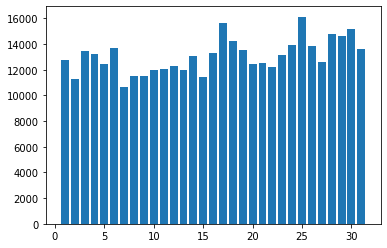

In [19]:
# tweet volume by day of the month

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).day as day, count(t) as total_tweets "
    "return day, total_tweets "
    "order by day asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.day, height=result_cons.total_tweets)

In [44]:
# 17 de mayo
consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 17 "
    "with h, count(t) as tweets "
    "return h.tag as tag, tweets "
    "order by tweets desc "
    "limit 10"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,tag,tweets
0,ciclonextratropical,103
1,peñarol,71
2,elclubgigante,66
3,uruguay,56
4,libertadores,51
5,vamoscarbonero,45
6,puntadeleste,44
7,yakecan,38
8,ciclonsubtropical,36
9,mayomesdelamemoria,33


Jueves 17 de mayo: Jugó peñarol en la Libertadores y fue el día del ciclón subtropical.

In [46]:
# 25 de mayo
consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 25 "
    "with h, count(t) as tweets "
    "return h.tag as tag, tweets "
    "order by tweets desc "
    "limit 15"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,tag,tweets
0,peñarol,83
1,libertadores,80
2,vamoscarbonero,53
3,elclubgigante,52
4,colón,42
5,122añosdelgpc,29
6,ahora,27
7,ltwtmontevideo,27
8,elhoteldelosfamosos,26
9,uruguay,22


25 de mayo: Jugó peñarol en la Libertadores, 122 años del Gran Parque Central

In [47]:
# 28-30 de mayo
consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day in [28,29,30] "
    "with h, count(t) as tweets "
    "return h.tag as tag, tweets "
    "order by tweets desc "
    "limit 15"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,tag,tweets
0,monacogp,136
1,puntopenalenel10,111
2,uruguay,111
3,uclfinal,109
4,mytopfollowers,94
5,f1,86
6,teamverano,77
7,elpeorgobiernodelahistoria,77
8,peñarol,75
9,elclubgigante,68


28-30 de mayo: 29 Gran Premio de Mónaco (F1), 28 final UEFA Champions League, Hizo frío: "Este frío es insalubre no seas malo 🥶 #TeamVerano siempre"

<BarContainer object of 24 artists>

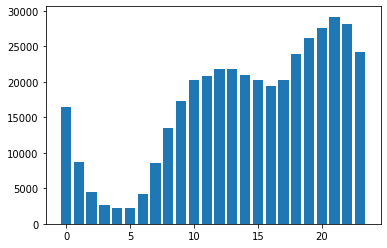

In [21]:
# tweet volume by hour of the day

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).hour as hour, count(t) as total_tweets "
    "return hour, total_tweets "
    "order by hour asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.hour, height=result_cons.total_tweets)

In [22]:
# tweet volume by department

consulta = (
    "match (t:Tweet {country: 'UY'}) "
    "with t.department as department, count(t) as total_tweets "
    "where total_tweets > 1000 "
    "return department, total_tweets "
    "order by total_tweets desc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,department,total_tweets
0,Montevideo,169267
1,Canelones,29638
2,Maldonado,22716
3,Colonia,9406
4,Salto,5323
5,San José,4704
6,Soriano,4109
7,Paysandú,3739
8,Florida,3314
9,Cerro Largo,3237


In [40]:
# Create an undirected projection of the graph and store it on the catalog

nodos_tweet = (
    "CALL gds.graph.project('tweets_undirected', ['User', 'Tweet'], {relType: {type: '*', orientation: 'UNDIRECTED', properties: {} } }) "
)

#evaluamos las consultas
tweets_undirected=graph.run(nodos_tweet).to_data_frame() 

tweets_undirected

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'relType': {'orientation': 'UNDIRECTED', 'agg...",tweets_undirected,461252,2113212,668


In [41]:
# Retrieve all graphs on the catalog to see if it was stored correctly

query = (
    "CALL gds.graph.list() "
)

#evaluamos las consultas
tweets=graph.run(query).to_data_frame() 

tweets

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 35, 'min': 0, 'max': 6744, 'mean': 4.5...",tweets_undirected,neo4j,20 MiB,21543389,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-18T18:07:09.587514000-03:00,2022-06-18T18:07:10.268256000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."
1,"{'p99': 35, 'min': 0, 'max': 6744, 'mean': 4.6...",in-memory-graph-1655569163960,neo4j,20 MiB,21685434,474136,2196776,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-18T13:33:27.376221000-03:00,2022-06-18T13:33:27.853786000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."
2,"{'p99': 35, 'min': 0, 'max': 6744, 'mean': 4.5...",tweets_no_hashtags,neo4j,20 MiB,21547229,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-18T18:02:46.443673000-03:00,2022-06-18T18:02:47.002939000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."


In [42]:
# Louvain community detection

consulta = (
  "CALL gds.louvain.stream('tweets_undirected') "
  "YIELD nodeId, communityId "
  "WITH communityId, count(nodeId) as size, "
  "collect(nodeId) as ids "
  "MATCH (u:User)-->(t:Tweet)-[*1..2]->(n) "
  "WHERE id(u) in ids "
  "AND (n:Hashtag or n:User) " 
  "WITH communityId, size,  count(t) as count, n.tag as tag, n.name as name "
  "ORDER BY count(t) DESC "
  "RETURN communityId, size, collect(name)[0..15] AS users, collect(tag)[0..15] AS hashtags "
  "ORDER BY size DESC "
  "LIMIT 25"

)

result_cons=graph.run(consulta).to_data_frame() 
pd.set_option('max_colwidth', None)
display(result_cons)
pd.set_option('max_colwidth', 50)

,communityId,size,users,hashtags
0,79423,29429,"[Graciela Bianchi, leo sarro press, Luis Lacalle Pou, Frente Amplio, EL PAÍS, GRAZIANO PASCALE, Sebas1, Rudhy Weiss, MonicaBatlle, Montevideo Portal, Romina Pesce, Adry More😜, Yamandú Orsi, Telemundo, Sebastian Da Silva]","[uruguay, hayordendenoaflojar, mayomesdelamemoria, marchadelsilencio2022, porquetodosesabe, eltuitazo2, santoyseña, 1demayo, elpeorgobiernodelahistoria, lamascarauy, peñarol, malospensamientos, hoy, ladiariajusticia, laentrevista]"
1,112234,27610,"[Nacional, 𝕴𝖓𝖘𝖔𝖕𝖔𝖗𝖙𝖆𝖇𝖑𝖊𝖒𝖊𝖓𝖙𝖊 𝕭𝖔𝖑𝖘𝖔, CONMEBOL Libertadores, laabdon.com.uy, 🇫🇷BOLSO AMARTE ES UN PLACER, PASIÓN TRICOLOR ((1010 Am)), Mauri Pérez, Lea Garcia , Valentín Canale 🎙🇳🇱, Jorge Savia, Estudiantes de La Plata, Carmen rinaldi❤⚪💙, PEÑAROL, Dahi🇱🇺, Lucas]","[elclubgigante, nacional, libertadores, orgullonacional, decano1solo, jueganacional, puntopenalenel10, 123años, laradiodelhincha, mayotricolor, sudamericana, 123añosdeverdad, oídossanos, canterainagotable, lafiestadelhincha]"
2,134385,24980,"[PEÑAROL, Negro y de Peñarol ™, Nati, PEÑAROL | Basketball, Punto Penal, Nacional, Wilson Méndez, TONGA, Cecilia Magdalena 🖐🏻, PUMA Uruguay, me dicen Fidel, BUYSAN, Martin Charquero, padreydecano.com, MANYANONYMOUS 💛🖤]","[peñarol, vamoscarbonero, puntopenalenel10, copaofi, libertadores, vamoslavalleja, nacional, apertura2022, todosjuntos, elequipoquenosune, lamascarauy, marchadelsilencio2022, nuncamasterrorismodeestado, espnenstarplus, ultimoalarco]"
3,54001,22863,"[JACK_TORRANCE⬆️, ☪️🅰️®️🛴🌎💰, Radio Belcha®, India🇺🇾, Laura, Diego, AmableDonante, Daniel Bengoa, Stepha, Mika, medicenrubia, San🌻dra, edu, Carol💫, Nicolás Hidalgo]","[f1, monacogp, laradioestuya, miamigp, marchadelsilencio2022, f12022, todossomosfamiliares, lamascarauy, mayomesdelamemoria, uruguay, essereferrari, tip, nuevafotodeperfil, teaminvierno, gpmónaco]"
4,40015,16773,"[Isabel_, gaby 💖💙❤️, Lunaro🎶🎼, Vicky, Jazmín 💙🇺🇾, Silvia, Genny Rodríguez, Jacquelin Sánchez Quintero, Gladys Nohemi, Toñi Valiente. ® ™, ANALI BENTENCOURT, Joyce 🐶🐶🐶🐱, Luis Pagani, Pablo ⛩️, Sonia Maldonado]","[mytopfollowers, grupodeamigosentwitter, tiktok, nuevafotodeperfil, lunagitana, hayordendenoaflojar, teamverano, uruguay, lavidaesbella, seanfelices, buenlunes, sefeliz, inflacion, lamascarauy, teaminvierno]"
5,100987,14613,"[Luis Lacalle Pou, Luis Alberto Heber, Daniel Salinas, Partido Nacional, MSP - Uruguay, Jose Luis Satdjian, Ministerio de Desarrollo Social, Lorena Ponce de León, Sebastian Da Silva, Alfin, Ministerio del Interior, Martin Lema, ASSE Comunica, Pablo Mieres, Javier García]","[hayordendenoaflojar, uruguay, haciauncompromisonacional, ahora, mayomesdelamemoria, marchadelsilencio2022, calibertades25, somosdelpueblo, photography, fotografia, renunciaheber, elclubgigante, lamascarauy, elpeorgobiernodelahistoria, montevideo]"
6,193336,12934,"[Gabriela, Jorge Andrés, Subrayado, Jenny Parada Martino, Mika, Bea, Luis Lacalle Pou, Gus⛵⚓⚓, Alejandro 🇺🇾🇪🇦🇨🇵, Mario Invernizzi, rita silvan, Harley, Graciela Bianchi, ☪️🅰️®️🛴🌎💰, Telemundo]","[marchadelsilencio2022, renunciaheber, mayomesdelamemoria, ahora, elpeorgobiernodelahistoria, todossomosfamiliares, polémicaenel10, uruguay, blancospillos, presente, lamascarauy, piriápolis, intrusos, elpeorpresidentedelahistoria, dondeestan]"
7,447429,10585,"[💫💫Estela❤️😷😷🏆🖤💛, Alejandro Raffo, Majo, Graciela Gadea, Ricardo Pons, Nestor Grajales, Julio Cesar Pradie Colmán, Flora Cukierman, jose ernesto costemalle, MaRosa, CIUDADANOJorgeCASTRO, Nora 🦋💐🌸, Maria, Mi Nona Celia, Luis Lacalle Pou]","[felizviernes, felizjueves, felizmiercoles, nuevafotodeperfil, mytopfollowers, felizsabadoatodos, felizmartesatodos, felizviernesatodos, pintouruguay, eltuitazo2, felizsabado, redwilsonista, juventudredwilsonista, felizmiercolesatodos, teamverano]"
8,186900,10245,"[Club Atlético Aguada, PEÑAROL | Basketball, FUBB, Pablo Batista, ✨Val✨, PablO RiverA ©, Pablo , Daniel , Liga Uruguaya de Básquetbol (Oficial), Franco Fernández, Hinchada Aguatera, Salvador,

In [39]:
# Drop graph projection from catalog
drop = (
    "CALL gds.graph.drop('tweets_undirected')"
)

result_drop = graph.run(drop).to_data_frame()
result_drop

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `tweets_undirected` does not exist on database `neo4j`. It might exist on another database.